# Model Development
Jupyter Notebook used to develop the Machine Learning model for classifying various house plant species.

### **Setup:**

Before running this notebook, make sure to run the data cleaning notebook at `/ModelDev/data_cleaning.ipynb`.

---

### Constants

In [1]:
BASE_DIR = '../Data/house_plant_species'
""" Folder path to the base directory containing species subfolders with images. """

' Folder path to the base directory containing species subfolders with images. '

### Extract labels

In [2]:
# Obtain a list of subfolders
import os

subfolders = []
dir_content = os.listdir(BASE_DIR)

for file_name in dir_content:
    file_path = os.path.join(BASE_DIR, file_name)
    if os.path.isdir(file_path):
        subfolders.append(file_name)

len(subfolders)

47

In [3]:
# Modify the subfolder names and save as labels
import re

class_labels = []

for folder in subfolders:
    # Replace spaces with underscores
    label = folder.replace(' ', '_')
    # Extract only the English name of the species
    match = re.match(r"^(.*?)_*\(", label)
    
    class_labels.append(match.group(1) if match else label)
    
class_labels

['African_Violet',
 'Aloe_Vera',
 'Anthurium',
 'Areca_Palm',
 'Asparagus_Fern',
 'Begonia',
 'Bird_of_Paradise',
 'Birds_Nest_Fern',
 'Boston_Fern',
 'Calathea',
 'Cast_Iron_Plant',
 'Chinese_evergreen',
 'Chinese_Money_Plant',
 'Christmas_Cactus',
 'Chrysanthemum',
 'Ctenanthe',
 'Daffodils',
 'Dracaena',
 'Dumb_Cane',
 'Elephant_Ear',
 'English_Ivy',
 'Hyacinth',
 'Iron_Cross_begonia',
 'Jade_plant',
 'Kalanchoe',
 'Lilium',
 'Lily_of_the_valley',
 'Money_Tree',
 'Monstera_Deliciosa',
 'Orchid',
 'Parlor_Palm',
 'Peace_lily',
 'Poinsettia',
 'Polka_Dot_Plant',
 'Ponytail_Palm',
 'Pothos',
 'Prayer_Plant',
 'Rattlesnake_Plant',
 'Rubber_Plant',
 'Sago_Palm',
 'Schefflera',
 'Snake_plant',
 'Tradescantia',
 'Tulip',
 'Venus_Flytrap',
 'Yucca',
 'ZZ_Plant']

In [4]:
# Create a label mapping
label_mapping = {}

for i in range(len(class_labels)):
    label_mapping[class_labels[i]] = i

label_mapping

{'African_Violet': 0,
 'Aloe_Vera': 1,
 'Anthurium': 2,
 'Areca_Palm': 3,
 'Asparagus_Fern': 4,
 'Begonia': 5,
 'Bird_of_Paradise': 6,
 'Birds_Nest_Fern': 7,
 'Boston_Fern': 8,
 'Calathea': 9,
 'Cast_Iron_Plant': 10,
 'Chinese_evergreen': 11,
 'Chinese_Money_Plant': 12,
 'Christmas_Cactus': 13,
 'Chrysanthemum': 14,
 'Ctenanthe': 15,
 'Daffodils': 16,
 'Dracaena': 17,
 'Dumb_Cane': 18,
 'Elephant_Ear': 19,
 'English_Ivy': 20,
 'Hyacinth': 21,
 'Iron_Cross_begonia': 22,
 'Jade_plant': 23,
 'Kalanchoe': 24,
 'Lilium': 25,
 'Lily_of_the_valley': 26,
 'Money_Tree': 27,
 'Monstera_Deliciosa': 28,
 'Orchid': 29,
 'Parlor_Palm': 30,
 'Peace_lily': 31,
 'Poinsettia': 32,
 'Polka_Dot_Plant': 33,
 'Ponytail_Palm': 34,
 'Pothos': 35,
 'Prayer_Plant': 36,
 'Rattlesnake_Plant': 37,
 'Rubber_Plant': 38,
 'Sago_Palm': 39,
 'Schefflera': 40,
 'Snake_plant': 41,
 'Tradescantia': 42,
 'Tulip': 43,
 'Venus_Flytrap': 44,
 'Yucca': 45,
 'ZZ_Plant': 46}

### Preprocess images

**Find the optimal image size**

In [5]:
# Load 10 sample images
from skimage.io import imread

sample_images = []

for folder in subfolders[:10]:
    folder_path = os.path.join(BASE_DIR, folder)
    image_name = os.listdir(folder_path)[0]
    image_path = os.path.join(folder_path, image_name)

    image = imread(image_path)
    sample_images.append(image)

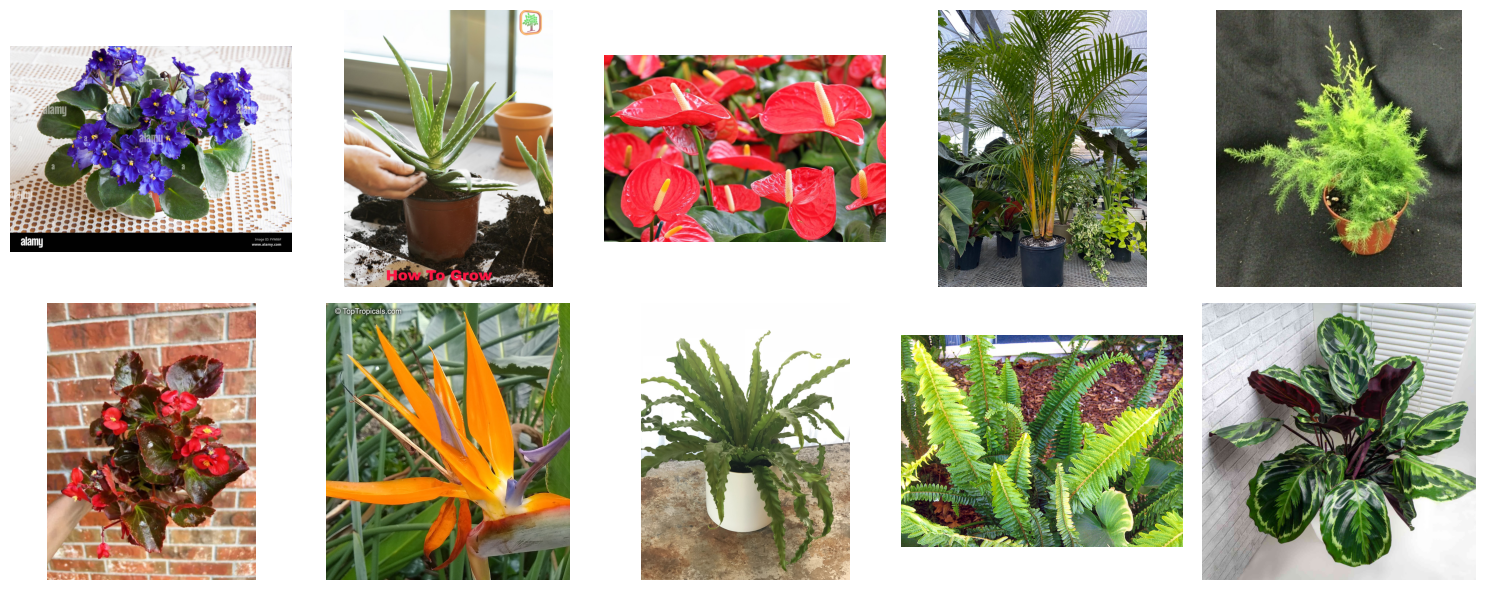

In [6]:
# Display the sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, image in enumerate(sample_images):
        axes[i].imshow(image)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

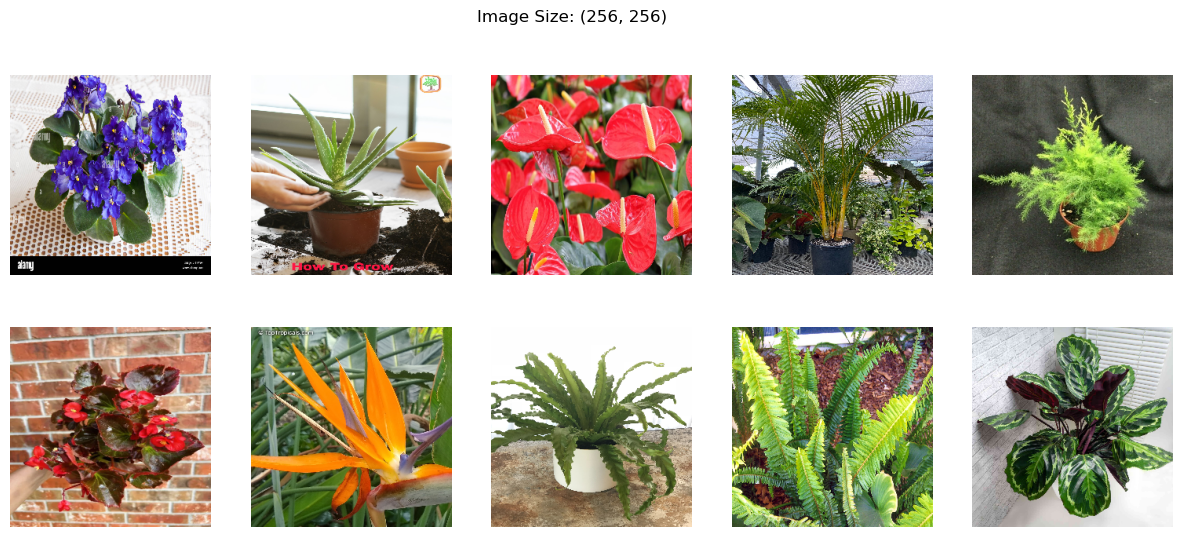

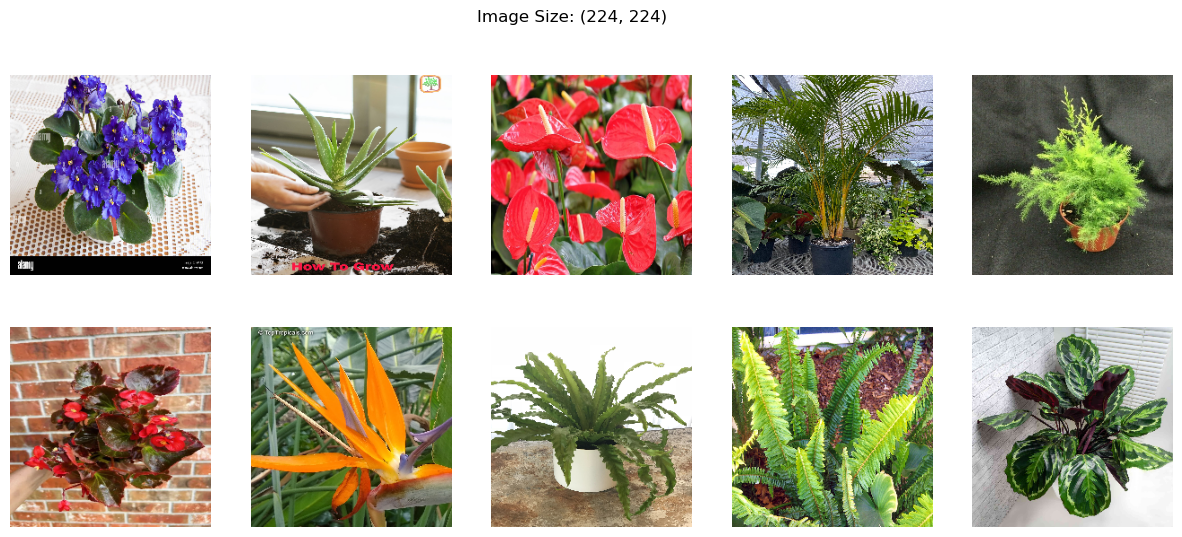

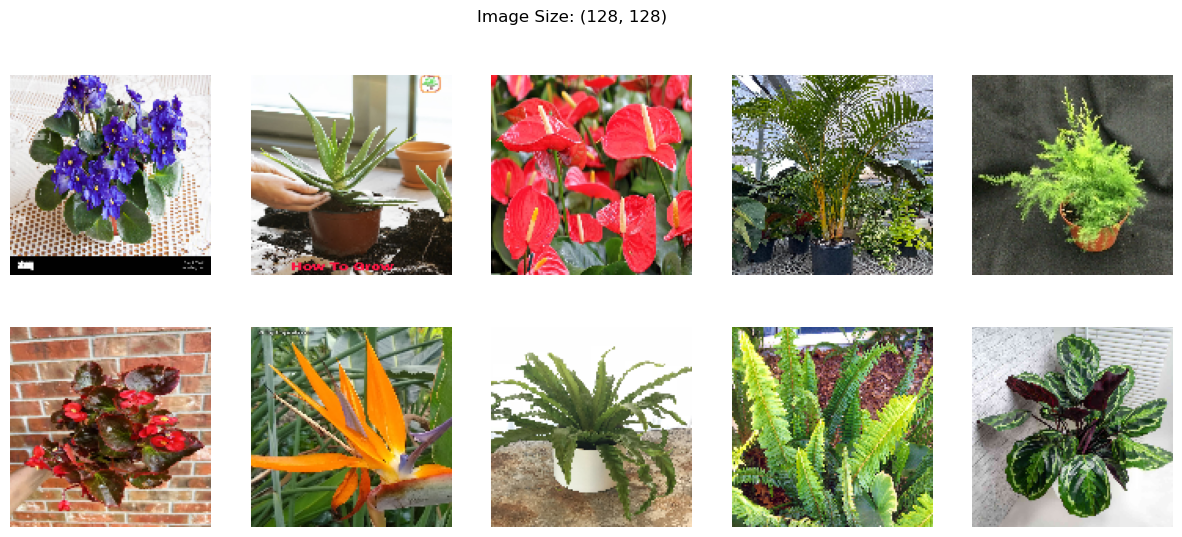

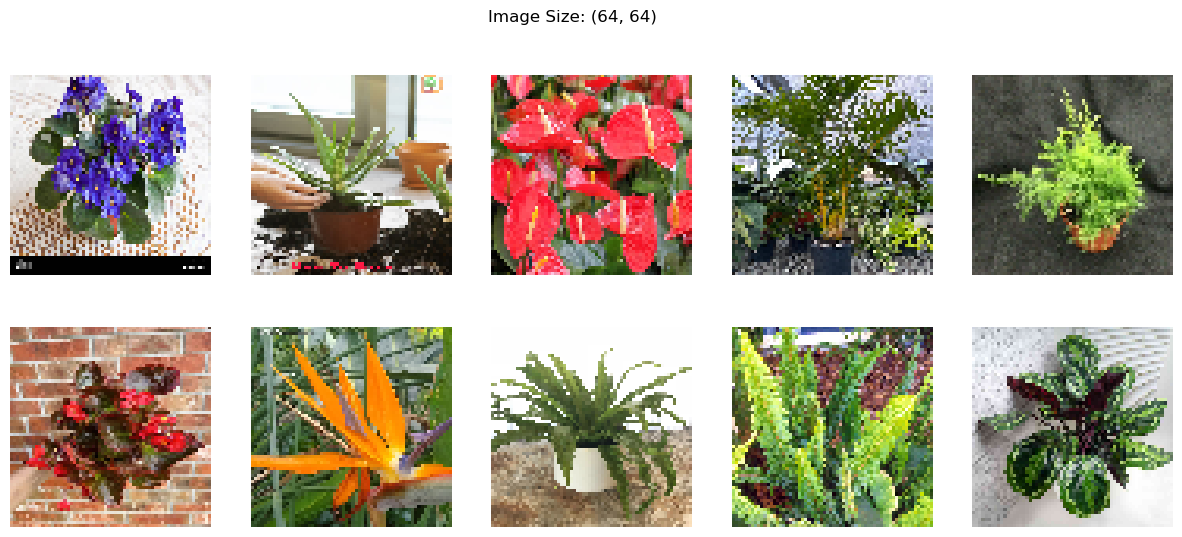

In [7]:
# Try different image sizes
import cv2

target_sizes = [(256, 256), (224, 224), (128, 128), (64,64)]

for size in target_sizes:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, image in enumerate(sample_images):
            image = cv2.resize(image, size)
            axes[i].imshow(image)
            axes[i].axis('off')

    fig.suptitle(f'Image Size: {size}')
    plt.show()

The image size 128x128 seems to preserve enough details. 

In [8]:
target_size = (128, 128)

### Load and split the dataset

**Helper functions for reproducability**

In [9]:
# Load features and labels
import numpy as np

def get_features_and_labels():
    """
    Extracts features and labels from a folder.

    Args:
        base_dir (str): The base directory containing subfolders for each class.
        class_labels (list): A list of class names corresponding to the subfolder names in `base_dir`.
        target_size (tuple): The desired dimensions (width, height) for resizing images.

    Returns:
        tuple: 
            - X (numpy.ndarray): Array of preprocessed image data.
            - y (numpy.ndarray): Array of corresponding class labels
    """
    X = []
    y = []

    for i in range(len(class_labels)):
        folder_path = os.path.join(BASE_DIR, subfolders[i])
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = imread(image_path)

            # If the image has 4 channels, drop the alpha channel
            if image.shape[2] == 4:
                image = image[:, :, :3]
                
            # Resize the image
            image_resized = cv2.resize(image, target_size)
            
            X.append(image_resized)
            y.append(class_labels[i])

    return np.array(X), np.array(y)

In [16]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def split_dataset(X, y, test_size=0.1, val_size=0.2, random_state=42):
    """
    Splits the dataset into training, validation, and test sets, and converts string labels to numerical labels.

    Args:
        X (numpy.ndarray): Feature dataset.
        y (numpy.ndarray): Corresponding labels for the dataset.
        label_mapping (dict): A dictionary mapping string labels to numerical values.
        test_size (float): Proportion of the dataset to be used as the test set.
        val_size (float): Proportion of the training set to be used as the validation set.
        random_state (int): Seed for reproducibility of the split.

    Returns:
        tuple: 
            - X_train (numpy.ndarray): Training features.
            - X_val (numpy.ndarray): Validation features.
            - X_test (numpy.ndarray): Test features.
            - y_train (numpy.ndarray): Training labels (numerical).
            - y_val (numpy.ndarray): Validation labels (numerical).
            - y_test (numpy.ndarray): Test labels (numerical).
    """
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size,
        random_state=random_state, stratify=y
    )

    # Split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, 
        random_state=random_state, stratify=y_train
    )

    # Convert string labels to numerical labels using label mapping
    y_train = np.array([label_mapping[label] for label in y_train])
    y_val = np.array([label_mapping[label] for label in y_val])
    y_test = np.array([label_mapping[label] for label in y_test])

    # Preprocess each set
    X_train, y_train = X_train.reshape(
        (X_train.shape[0], X_train.shape[1]*X_train.shape[1]*X_train.shape[3])
    ).astype('float32'), to_categorical(y_train)

    X_val, y_val = X_val.reshape(
        (X_val.shape[0], X_val.shape[1]*X_val.shape[1]*X_val.shape[3])
    ).astype('float32'), to_categorical(y_val)

    X_test, y_test = X_test.reshape(
        (X_test.shape[0], X_test.shape[1]*X_test.shape[1]*X_test.shape[3])
    ).astype('float32'), to_categorical(y_test)

    # Print dataset sizes
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    return X_train, X_val, X_test, y_train, y_val, y_test

**Retreive the dataset and split into sets**

In [11]:
X, y = get_features_and_labels()

In [14]:
X.shape, y.shape

((14790, 128, 128, 3), (14790,))

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)

Training set size: 10648
Validation set size: 2663
Test set size: 1479


### Baselines

In [21]:
# Random Guess
random_guess = 100 / len(class_labels)
random_guess

2.127659574468085

In [24]:
# Basic Model Accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, input_shape=(49152,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(47, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping as a callback
monitor_val_loss = EarlyStopping(monitor='val_loss',
                                 patience=3,
                                 restore_best_weights=True)

# Train
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=20,
                    callbacks=[monitor_val_loss],
                    validation_data=(X_val, y_val))

# Evaluate
model.evaluate(X_test, y_test)


Epoch 1/10


533/533 [==============================] - 18s 33ms/step - loss: 261.9716 - accuracy: 0.0345 - val_loss: 3.8382 - val_accuracy: 0.0368
Epoch 2/10
533/533 [==============================] - 17s 32ms/step - loss: 3.8536 - accuracy: 0.0363 - val_loss: 3.8164 - val_accuracy: 0.0368
Epoch 3/10
533/533 [==============================] - 17s 31ms/step - loss: 3.8129 - accuracy: 0.0365 - val_loss: 3.8060 - val_accuracy: 0.0368
Epoch 4/10
533/533 [==============================] - 17s 31ms/step - loss: 3.8063 - accuracy: 0.0367 - val_loss: 3.8004 - val_accuracy: 0.0368
Epoch 5/10
533/533 [==============================] - 17s 31ms/step - loss: 3.8165 - accuracy: 0.0366 - val_loss: 4.0104 - val_accuracy: 0.0376
Epoch 6/10
533/533 [==============================] - 17s 31ms/step - loss: 17.4758 - accuracy: 0.0361 - val_loss: 3.7956 - val_accuracy: 0.0368
Epoch 7/10
533/533 [==============================] - 17s 31ms/step - loss: 3.7965 - accuracy: 0.0365 - val_loss: 3.7946 - val_acc

[3.794679880142212, 0.03651115670800209]